
0: 448x640 1 dog, 1 cat, 57.4ms
Speed: 1.5ms preprocess, 57.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)
[{'class': 0, 'name': 'dog', 'skelton': [[0, 1], [0, 2], [0, 7], [0, 8], [1, 13], [1, 14], [2, 3], [2, 4], [3, 4], [3, 5], [4, 6], [7, 9], [8, 10], [9, 11], [10, 12], [13, 15], [14, 16], [15, 17], [16, 18]], 'keypoints': [[152.39227294921875, 72.64742279052734], [232.02955627441406, 86.28504180908203], [118.14762115478516, 54.4095573425293], [120.5045166015625, 55.783565521240234], [112.5345687866211, 65.34938049316406], [122.50463104248047, 47.83352279663086], [122.3548583984375, 46.83045959472656], [135.5773162841797, 114.07324981689453], [136.0035858154297, 115.63447570800781], [211.25511169433594, 113.91053009033203], [206.74024963378906, 118.1813735961914], [130.73594665527344, 138.68882751464844], [129.06777954101562, 135.99986267089844], [221.18479919433594, 137.17771911621094], [219.7726593017578, 139.55645751953125], [130.64236450195312, 153.8070373

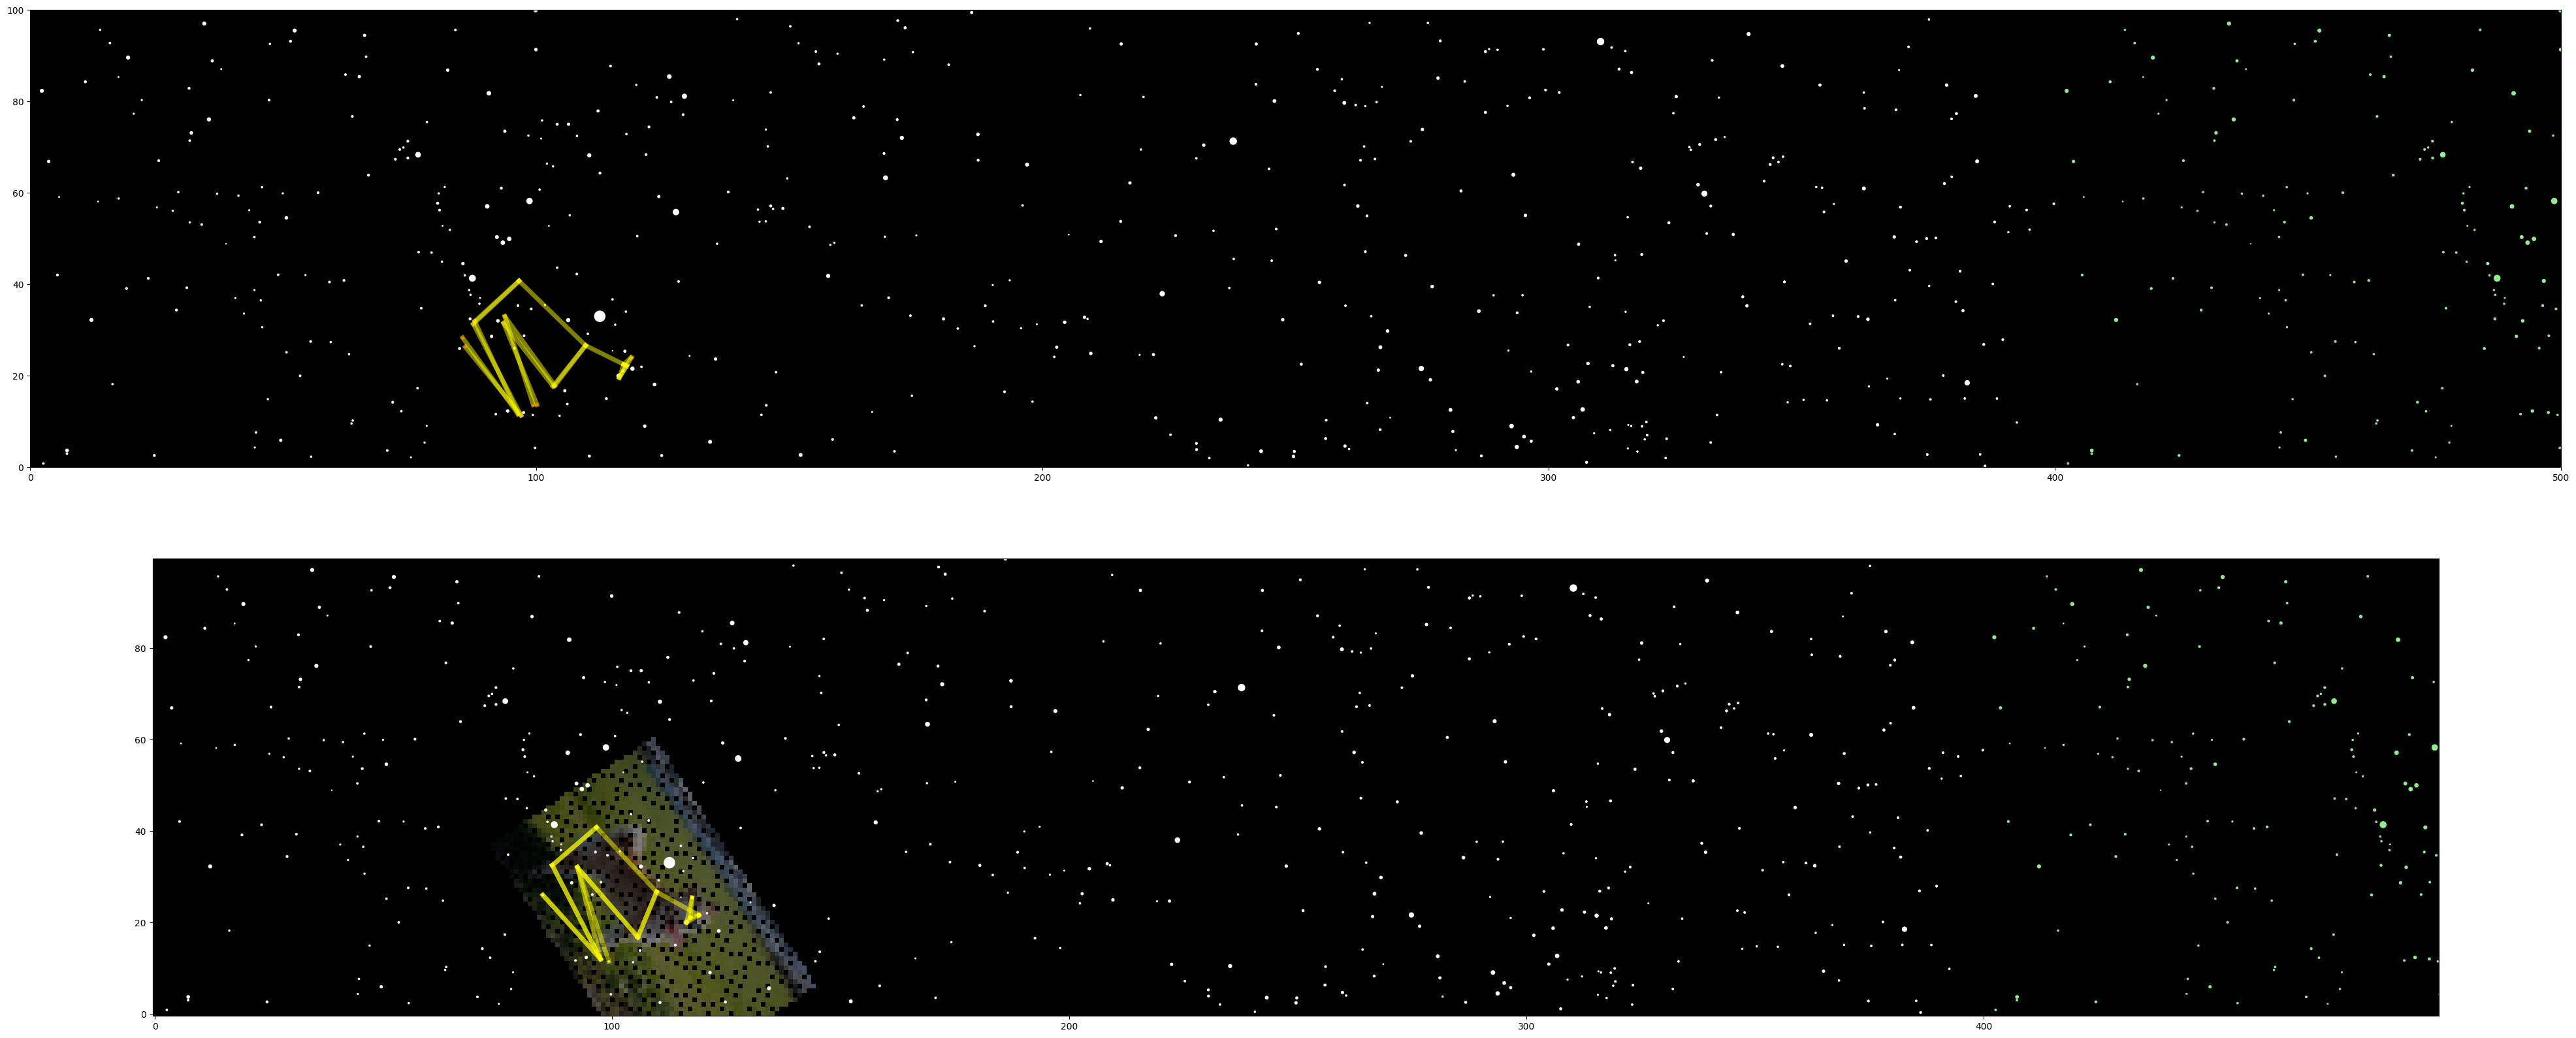

In [2]:
import cv2
import sys
import os
from ultralytics import YOLO
from detect_points import Predict_keypoints

import plot_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import importlib
importlib.reload(plot_function)
from PIL import Image
from plot_function import calc_theta,match_points,calc_edge_list,regularize_points,reshape_and_match_image
from plot_function import Local,Search_min

model = os.getcwd() + '/best.pt'
'''
args = sys.argv
img = os.getcwd() + '/input/images/' + args[1]
'''
img='./input/images/dog.jpeg'
keypoints = Predict_keypoints(model, img)
print(keypoints)

name=keypoints[0]['name']
point_edge_list=keypoints[0]['skelton']
raw_points=np.array(keypoints[0]['keypoints'])


north=Local('north')
south=Local('south')
equator=Local('equator')
ex_equator=Local('ex_equator')

all_locals=Search_min([north,south,equator,ex_equator])

points,points_norm,points_theta=regularize_points(raw_points)

all_locals.set_para()

points_size=len(points)

for direction in all_locals.local_list: 
    print(direction)
    star_data=direction.star_data  
    reshaped_position=direction.reshaped_position
    x,y,lum,HIPnum=star_data[:,0],star_data[:,1],star_data[:,2],star_data[:,3]
    a_x=reshaped_position[:,0]
    a_y=reshaped_position[:,1]
    size=7*np.exp(-1*(lum+2)*np.log(2))
    penalty_of_size=8*np.exp(-5*size*np.log(2)-1)
    direction.min_dist=float('inf')
    for edge in direction.edge_list:
        node1,node2=edge
        star_1=reshaped_position[node1]
        star_2=reshaped_position[node2]
        norm=np.linalg.norm(star_2-star_1)
        theta=calc_theta(star_2-star_1)
        a_points=match_points(points,norm,theta,star_1)
        near_stars=[-1 for _ in range(points_size)]
        dist=0
        for i in range(points_size):
            a_point=a_points[i]
            a_point_x=int(round(a_point[0],0))
            a_point_y=int(round(a_point[1],0))
            #ここの処理は変えたほうがいいかも
            if a_point_x<0 or a_point_x>=direction.dotsize_x or a_point_y<0 or a_point_y>=direction.dotsize_y:
                break
            indice3=direction.near_dot[a_point_y][a_point_x]
            nearest_star=np.array([a_x[indice3],a_y[indice3]]).reshape(-1)
            dist+=np.sum((a_point-nearest_star)**2)/(norm**(2))
            near_stars[i]=indice3
            if dist>direction.min_dist:
                break
            if i==points_size-1:
                shape_penalty_rate=0
                for j in range(points_size):
                    shape_penalty_rate+=penalty_of_size[near_stars[j]]
                    for k in range(j+1,points_size):
                        if near_stars[j]==near_stars[k]:
                            if (j,k) in direction.edge_list:
                                shape_penalty_rate+=0.5
                            else:
                                shape_penalty_rate+=1
                shape_penalty_rate+=norm/30
                dist=dist*(1+shape_penalty_rate)
                if dist>direction.min_dist:
                    break
                direction.min_dist=dist 
                direction.min_stars=near_stars
                direction.min_a_points=a_points
                direction.min_theta=theta
                direction.min_norm=norm
            if dist>direction.min_dist:
                break
    print(direction.min_dist)

direction=all_locals.search_min_local()

image_path=img

resize_rate=direction.min_norm/points_norm
rotate_theta=direction.min_theta-points_theta

reshaped_image_array=reshape_and_match_image(direction,image_path,resize_rate,rotate_theta ,raw_points[0])

all_locals.show_result(point_edge_list,reshaped_image_array)
